# Estimating $k_j$

>Next, I'd get it working with less and less information assumed to be known. You could either start inferring the participant's stage of disease or the order for biomarkers next. I'd probably do the participant's state of disease.

>For the stage of disease for a participant, I'd do probably derive a gibbs sampling step by calculating each stage's relative likelihood based on the probabilities of the biomarker values ASSUMING they are at that stage. Then you normalize and sample from that discrete distribution.  

## Known $\theta$ and $\phi$

First, let us assume that we know $\theta$ and $\phi$. We also know at which disease stage a biomarker is affected. Basically, in the `data` below, we do not have these two columns: `k_j` and `affected_or_not`. 

For each participant, I will iterate through all possible stages. For each stage, I will calculate the likelihood of seeing the observed biomarker sequence of values using the following formula:

$$p(X_{j} | S , z_j = 1, k_j) = \prod_{i=1}^{k_j}{p(X_{S(i)j} \mid \theta_n )} \prod_{i=k_j+1}^N{p(X_{S(i)j} \mid \phi_n)}$$

Then the stage associated with the maximum likelihood will be the estimated disease stage for this participant. 


In [1]:
import pandas as pd 
import numpy as np 
import re 
import altair as alt 
import matplotlib.pyplot as plt 
data = pd.read_csv('data/participant_data.csv')
data.Biomarker = [re.sub("Biomarker ", "", text) for text in data.Biomarker.tolist()]
data.head()
# but remember that we do not know k_j which is what we are trying to estimate. 

,Biomarker,participant,measurement,k_j,S_n,affected_or_not
0,0,0,0.457546,8,7,affected
1,0,1,1.103317,7,7,affected
2,0,2,1.380441,9,7,affected
3,0,3,14.069878,3,7,not_affected
4,0,4,11.457832,0,7,not_affected


In [2]:
theta_phi = pd.read_csv('data/means_vars.csv')
theta_phi.head()

,biomarker,theta_mean,theta_var,phi_mean,phi_var
0,0,1.0,0.3,12.0,1.3
1,1,3.0,0.5,11.0,2.4
2,2,5.0,0.2,14.0,1.4
3,3,6.0,1.3,16.0,0.9
4,4,8.0,3.3,18.0,1.5


In [3]:
def compute_likelihood(theta_phi, biomarker, affected, measurement):
    '''Computes the likelihood of the given measurement data
    We know the normal distribution defined by either theta or phi
    and we know the measurement. This will give us the probability
    of the given measurement. 

    input:
    - theta_phi: the dataframe containing theta and phi values for each biomarker
    - biomarker: an integer between 0 and 9 
    - affected: boolean 
    - measurement: the observed value for a biomarker in a specific participant

    output: a number 
    '''
    biomarker_params = theta_phi[theta_phi.biomarker == biomarker].reset_index()
    mu = biomarker_params['theta_mean'][0] if affected else biomarker_params['phi_mean'][0]
    var = biomarker_params['theta_var'][0] if affected else biomarker_params['phi_var'][0]
    sigma = np.sqrt(var)
    return np.exp(-(measurement - mu)**2/(2*sigma**2))/np.sqrt(2*np.pi*sigma**2)

In [4]:
p_data = data[data.participant == 1].reset_index(drop= True)
p_data.k_j[0]
# biomarker_data = p_data[p_data.Biomarker == str(0)].reset_index(drop=True)
# biomarker_data

7

In [5]:
biomarkers = np.random.randint(0, 10, size = 10)
participants = data.participant.unique()
num_iterations = 1000
num_stages = len(data.S_n.unique())
estimated_stage_dic = {}
actual_stage_dic = {}

# stages = np.random.randint(0, num_stages, len(participants))

for p in participants:
    p_data = data[data.participant == p].reset_index(drop=True)
    actual_stage_dic[p] = p_data.k_j[0]
    stage_likelihood = np.zeros(num_stages)
    # assume participant is in this stage; compute the likelihood of seeing 
    # this sequence of observed biomarker measuremen
    # [0, 9]
    for k in range(num_stages):
        likelihood = 1 
        for biomarker in biomarkers:
            biomaker_data = p_data[p_data.Biomarker == str(biomarker)].reset_index(drop=True)
            measurement = biomaker_data.measurement[0]
            biomarker_stage = biomaker_data.S_n[0]
            affected = k >= biomarker_stage
            # the final updated likelihood is the likelihood of seeing 
            # this sequence of data of the total number of biomarkers 

            # This is using the equation here: https://ebm-book2.vercel.app/distributions.html#known-k-j
            likelihood *= compute_likelihood(
                theta_phi, biomarker, affected, measurement
            )

            # if the participant is in this stage, what is the likelihood of seeing this 
            # sequence of values
            stage_likelihood[k] = likelihood
    max_likelihood_stage = pd.Series(stage_likelihood).idxmax()
    estimated_stage_dic[p] = max_likelihood_stage           

In [6]:
estimated_stages = np.array(list(estimated_stage_dic.values()))
actual_stages = np.array(list(actual_stage_dic.values()))
differences = estimated_stages - actual_stages
# difference_df = pd.DataFrame(differences, columns=['discrepancy']).reset_index(names = ['participant'])
# difference_df.head()
# alt.Chart(difference_df).mark_circle(size = 60).encode(
#     x = "participant",
#     y = 'discrepancy'
# )

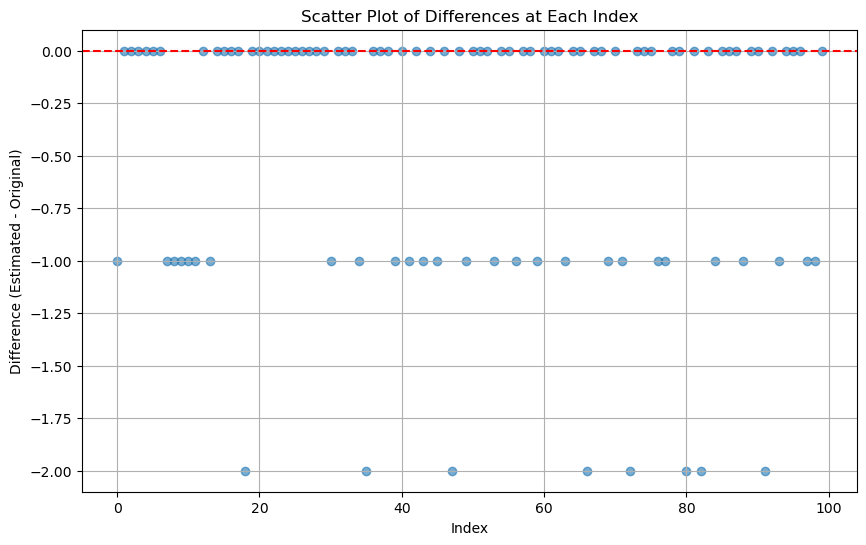

In [7]:
# 2. Scatter Plot of the Differences at each index
plt.figure(figsize=(10, 6))
plt.scatter(range(100), differences, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Scatter Plot of Differences at Each Index")
plt.xlabel("Index")
plt.ylabel("Difference (Estimated - Original)")
plt.grid(True)
plt.show()
